## CS 591 S1 -- Summer 1, 2020 -- Introduction to Audio Programming in Python


### Author: Wayne Snyder

### Date: 5/28
### Purpose: 

This collects together the most important algorithms used in
CS 591;  for the most part
signals are manipulated as arrays, not as wave files.
This file assumes you have scipy and numpy.


Please look at the following resources to help you get up to speed on
Python for this class:

   - http://www.cs.bu.edu/fac/snyder/cs237/tutorials/LearningPython.html
 
   - <a href="https://www.cs.bu.edu/fac/snyder/cs237/tutorials/">Tutorials Directory for CS 237</a>

In [302]:
# General useful imports
import array
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle
from numpy.random import random, randint, uniform
from math import gcd
from cmath import polar
from pylab import *
from scipy import signal


%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# population standard deviation
std(X)

# population variance
var(X)


# Calculate the covariance and correlation coefficient

def covariance(X,Y):
    return cov(X,Y,bias=True)[0][1]

def rho(X,Y):
    return corrcoef(X,Y)[0][1]

def R2(X,Y):
    return corrcoef(X,Y)[0][1] ** 2

# Utility functions

        
# Round to 2 decimal places
def round2(x):
    return np.around(x,2)

# Round to 4 decimal places
def round4(x):
    return np.around(x,4)    
    
# least common multiple        
def lcm(n,m):
    return (n*m)//gcd(n,m)

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != numpy.ndarray:
        return max(min(X[k],MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X


## Review of  Python  for Audio Programming

### Basic list and array manipulation using Numpy

We will first review the most important features of Python that we will need in this class.

### Basic list and array manipulation using Numpy

We will use 1-dimensional Numpy arrays as our basic data structure for audio signals; for a fuller tutorial, see for example the following (there are many on YouTube):

https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html

In [303]:
# Basic manipulation of numpy arrays

# Constructing an array

X = np.array([1,2,3])

Y = np.array([4,5,6])

Emp = np.array([])

# creating blank arrays

np.zeros(10)   # => array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

# Numpy arrays behave just like lists most of the time

X[2]
X[-1]
len(X)

# find length

X.size

# make a copy

X.copy()

# split an array between certain indices

x = [1, 2, 3, 99, 99, 3, 2, 1]
x1, x2, x3 = np.split(x, [3, 5])  # => [1 2 3] [99 99] [3 2 1]

# sort an array 

np.sort(X)

# concatenation of two arrays

np.concatenate([X,Y])     # => array([1, 2, 3, 4, 5, 6])

# Numpy allows pairwise application of arithmetic operations:

# With a scalar:

X + 10     # =>  array([11, 12, 13])
X * 2      # =>  array([2, 4, 6])
2 * X - 1  # => array([1, 3, 5])
X**2

array([1, 4, 9])

In [304]:
# With another array

X + Y  # =>  array([5, 7, 9])
X - Y  # =>  array([-3, -3, -3])
X * Y  # =>  array([ 4, 10, 18])
X / Y  # =>  array([ 0.25,  0.4 ,  0.5 ])

array([ 0.25,  0.4 ,  0.5 ])

In [305]:
# dot product is a built-in operator:

X @ Y # =>   32

32

In [306]:
#  Many functions will work on numpy arrays as a whole

sqrt(X) # => array([ 1.        ,  1.41421356,  1.73205081])
sin(X)  # => array([ 0.84147098,  0.90929743,  0.14112001])
cos(X)  # => array([ 0.54030231, -0.41614684, -0.9899925 ])

array([ 0.54030231, -0.41614684, -0.9899925 ])

In [307]:
T = np.arange(100)
X = sin(2*np.pi*T)


## List/Array Comprehensions

A list comprehension is a great way to create lists with a minimum of fuss and bugs. 
They work with numpy arrays as well. 

The basic idea is that instead of creating an array by specifying every step, say like this:

In [308]:
# Create a list of the first 10 squares

L = np.zeros(10)         # create a list of 10 zeros
for k in range(len(L)):
    L[k] = (k+1)**2
L

array([   1.,    4.,    9.,   16.,   25.,   36.,   49.,   64.,   81.,  100.])

you can do it all in one line:

In [309]:
np.array(    [  (k+1)**2  for k in range(10)  ]    )

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100])

In [310]:
T = np.arange(100)
X = [ sin(2*pi*t) for t in T]
X

[0.0,
 -2.4492935982947064e-16,
 -4.8985871965894128e-16,
 -7.3478807948841188e-16,
 -9.7971743931788257e-16,
 -1.2246467991473533e-15,
 -1.4695761589768238e-15,
 -1.7145055188062944e-15,
 -1.9594348786357651e-15,
 -2.2043642384652358e-15,
 -2.4492935982947065e-15,
 -9.7996503157251783e-15,
 -2.9391523179536475e-15,
 3.9213456798178833e-15,
 -3.4290110376125889e-15,
 -1.0779367755043061e-14,
 -3.9188697572715303e-15,
 2.9416282405000009e-15,
 -4.4087284769304716e-15,
 -1.1759085194360944e-14,
 -4.898587196589413e-15,
 1.9619108011821185e-15,
 -1.9599300631450357e-14,
 -1.2738802633678827e-14,
 -5.878304635907295e-15,
 9.8219336186423597e-16,
 7.8426913596357665e-15,
 -1.3718520072996709e-14,
 -6.8580220752251778e-15,
 2.4759225463534308e-18,
 -2.1558735510086122e-14,
 -1.4698237512314591e-14,
 -7.8377395145430605e-15,
 -9.7724151677152916e-16,
 5.8832564810000018e-15,
 -1.5677954951632475e-14,
 -8.8174569538609433e-15,
 -1.9569589560894117e-15,
 -2.3518170388721888e-14,
 -1.66576723909

The idea is to collect together all instances of the expression at the beginning, for all values of k produces
by the for. Some examples may clarify. 

In [311]:
from random import random            # The function random() returns a random double in the range [0..1)

L2 = np.array([  random()  for k in range(10)  ])
print(L2)

[ 0.74716134  0.97204677  0.10657491  0.92558082  0.36403694  0.52320703
  0.86662402  0.4585385   0.66804249  0.46676442]


You can also use multiple for loops:

In [312]:
D = ['0','1','2','3','4']
L = ['A','B','C','D','E']
     
X = np.array([ d + el for d in D for el in L ])
print(X)

['0A' '0B' '0C' '0D' '0E' '1A' '1B' '1C' '1D' '1E' '2A' '2B' '2C' '2D' '2E'
 '3A' '3B' '3C' '3D' '3E' '4A' '4B' '4C' '4D' '4E']


List comprehensions can do a lot, especiallly if you use conditions in the "loop" part:

In [313]:
L3 = np.array([63,241,7,43,99,132,6,-3,71,235,24,66])  

# let's pick 63 as the "pivot" for quicksort and partition the list into those
# numbers less than 63 and those greater or equal:

left = np.array( [ x for x in L3 if x < 63 ] )
right = np.array( [ x for x in L3 if x >= 63 ] )

print(L3)
print(left)
print(right)

[ 63 241   7  43  99 132   6  -3  71 235  24  66]
[ 7 43  6 -3 24]
[ 63 241  99 132  71 235  66]


In [314]:
#  List comprehensions can be used to write very complicated algorithms with very few lines of code!

def quicksort(L):
    if(len(L) == 0):
        return np.array([])
    else:
        pivot = L[0]
        left  = np.array( [ x for x in L[1:] if x < pivot ] )      # partition list around pivot
        right = np.array( [ x for x in L[1:] if x >= pivot ] )
        return np.concatenate( [quicksort(left), [pivot], quicksort(right)] )

quicksort(L3)

array([  -3.,    6.,    7.,   24.,   43.,   63.,   66.,   71.,   99.,
        132.,  235.,  241.])

## Plotting Points

The <code>scatter(...)</code> function is used to plot points from a list of x values and the associated y values. 


This is the list of points: [(1, 2), (2, 3), (3, 6), (4, 8)]
They must be input to the function as separate lists:
	X = [1, 2, 3, 4]
	Y = [2, 3, 6, 8] 



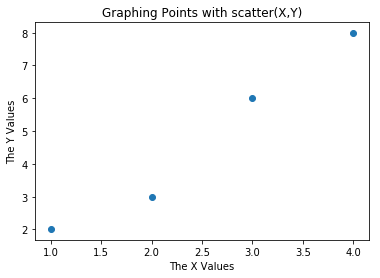

In [315]:
# To plot the points (1,2), (2,3), (3,6), (4,8) we would list the x values and the corresponding y values:
X = [1,2,3,4]
Y = [2,3,6,8]

print("\nThis is the list of points:",list(zip(X,Y)))
print("They must be input to the function as separate lists:")
print("\tX =",X)
print("\tY =",Y,"\n")
plt.scatter(X,Y)
plt.title('Graphing Points with scatter(X,Y)')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()



# Plotting Lines and Curves

If you call <code>plot(...)</code> instead of <code>scatter(...)</code> you will display a curve created by connecting the points with straight lines. Essentially you can only plot straight lines between points, but if the points are close together, you will not notice, and it will look like a smooth curve. 

## Plotting Points

The <code>scatter(...)</code> function is used to plot points from a list of x values and the associated y values. 


This is the list of points: [(1, 2), (2, 3), (3, 6), (4, 8)]
They must be input to the function as separate lists:
	X = [1, 2, 3, 4]
	Y = [2, 3, 6, 8] 



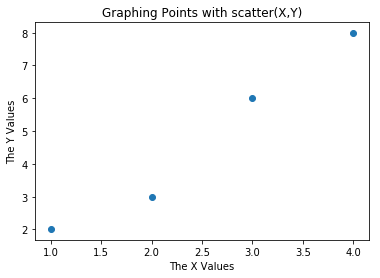

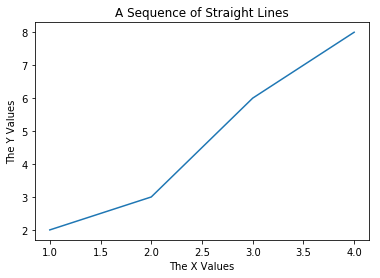

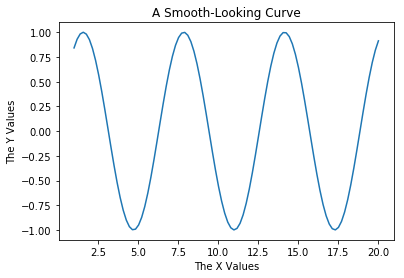

In [316]:
# To plot the points (1,2), (2,3), (3,6), (4,8) we would list the x values and the corresponding y values:
X = [1,2,3,4]
Y = [2,3,6,8]

print("\nThis is the list of points:",list(zip(X,Y)))
print("They must be input to the function as separate lists:")
print("\tX =",X)
print("\tY =",Y,"\n")
plt.scatter(X,Y)
plt.title('Graphing Points with scatter(X,Y)')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

# To plot a curve through the points (1,2), (2,3), (3,6), (4,8) we would use: 
plt.plot([1,2,3,4], [2,3,6,8])
plt.title('A Sequence of Straight Lines')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

X = np.linspace(1,20,100)            # returns a list of 100 equally-spaced values in the range [1..20]
Y = [np.sin(x) for x in X]
plt.plot(X,Y)
plt.title('A Smooth-Looking Curve')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

If you leave out the $X$ values, `plot(...)` will assume that you want the x-axis labeled 0, 1, ..., (len(X)-1),
corresponding to the labels on an array or list:

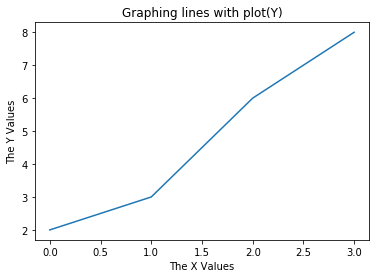

In [317]:
# Plot a list against the indices
Y = [2,3,6,8]

plt.plot(Y)
plt.title('Graphing lines with plot(Y)')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

If you want to do both, you can simply call both functions before you call show(). 

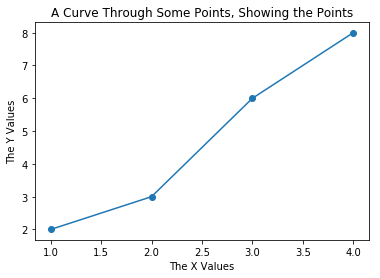

In [318]:
plt.scatter([1,2,3,4], [2,3,6,8])
plt.plot([1,2,3,4], [2,3,6,8])
plt.title('A Curve Through Some Points, Showing the Points')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

If you want to draw a single line from $(x_1,y_1)$ to $(x_2,y_2)$ you can plot $[x_1,x_2]$ and $[y_1,y_2].$

Here we have added a zero line to our sin curve:

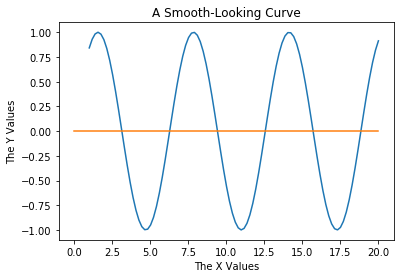

In [319]:
X = np.linspace(1,20,100)            # returns a list of 100 equally-spaced values in the range [1..20]
Y = [np.sin(x) for x in X]
plt.plot(X,Y)
plt.plot([0,20],[0,0])
plt.title('A Smooth-Looking Curve')
plt.xlabel("The X Values")
plt.ylabel("The Y Values")
plt.show()

#### For further details on drawing plots, particularly on color and format, see the Appendix at the end of this document

### Audio Programming with Wav Files

In [320]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = array.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(fname, X):
    X = [clip(x) for x in X]
    params = [1,2, SR , len(X), "NONE", None]
    data = array.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")
    

### Playing Audio Files from a Notebook

From:

 https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=sound#IPython.display.Audio


In [321]:
# Play audio from a URL

# Audio("http://www.nch.com.au/acm/8k16bitpcm.wav")  
Audio(url="http://www.w3schools.com/html/horse.ogg")

In [322]:
# Play audio from a file

Audio('10 My Old Kentucky Home (Instrumental).mp3')  

# Audio(filename='/path/to/sound.ogg') 

In [1]:
# Play audio from a list or array -- NOTE: must specify framerate = sample rate using `rate=SR`. 
# In this option, the signal will be scaled so that it plays at maximum volume. 

T = np.linspace(0,5,SR*5)
data = sin(2*pi*220*T) + sin(2*pi*440*T) + sin(2*pi*660*T)

Audio(data,rate=SR)
max(data)

NameError: name 'np' is not defined

In [324]:
# Can also do stereo or more channels
dataleft = sin(2*pi*220*T)
dataright = sin(2*pi*224*T)
Audio([dataleft, dataright],rate=SR)

# Audio(b'RAW_WAV_DATA..')  # From bytes
# Audio(data=b'RAW_WAV_DATA..')    

### Displaying Signals

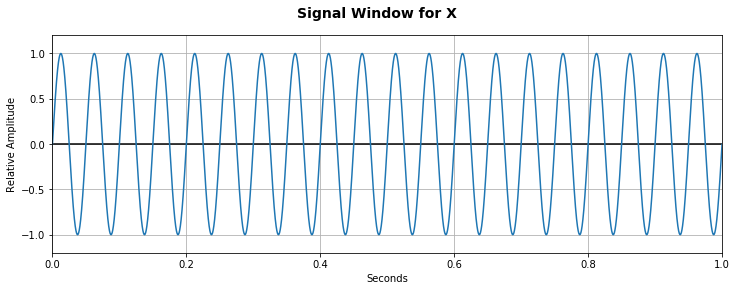

In [336]:
def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 20
s = 1

T = np.arange(SR*s)    # time in sample numbers  

X = MAX_AMP * np.sin( 2 * pi * f * T / SR ) 


displaySignal(X)



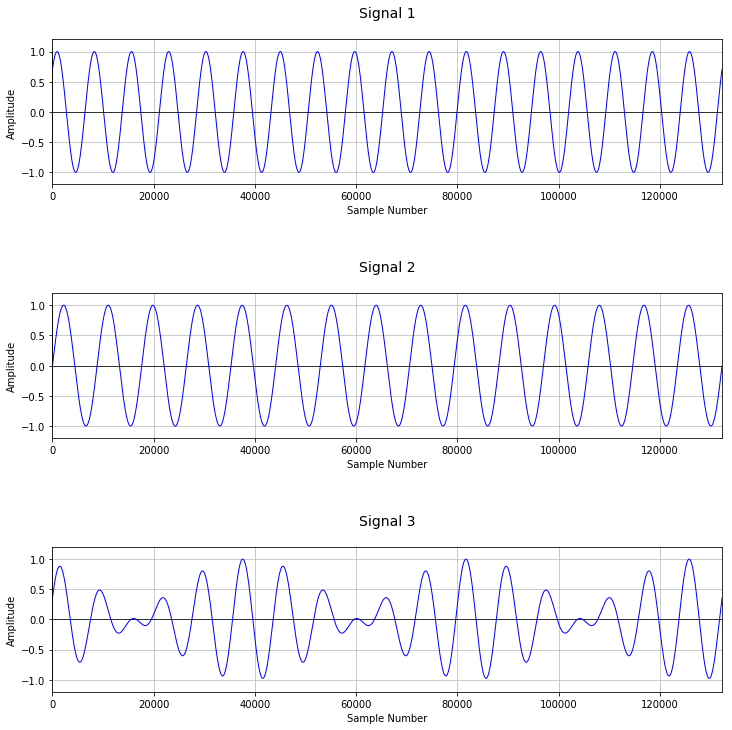

In [341]:
########### NOTE: In the following, we use a nice feature of matplotlib, that when the X axis   ################
###########       is omitted, and only the Y values given, then it assumes X = [0, 1, ..., len(Y)-1]  ##########

# This will display a list of signals in aligned subplots, with separate titles

def plotSignals(signals, titles=[]):
    print()
    if titles == []:
        if len(signals) > 1:
            titles = ['Signal ' + str(k+1) + '\n' for k in range(len(signals))]
        else:
            titles = ['Signal\n']
    else:
        titles = [t + '\n' for t in titles]
            
    number_of_subplots=len(signals)
    
    N = len(signals[0])

    fig = plt.figure(figsize=(12,number_of_subplots*4))
    fig.subplots_adjust(hspace=0.75)
    #fig.suptitle("Comparison ",fontsize=16)
    
    for i,v in enumerate(range(number_of_subplots)):
        v = v+1
        ax1 = subplot(number_of_subplots,1,v)
        
        ax1.set_ylabel('Amplitude')
        ax1.set_xlabel('Sample Number') 
        ax1.plot([0,N-1],[0,0],color='black',lw=0.75)
        ax1.plot([0,0],[-1,1],color='black',lw=0.75)    
        ax1.set_ylim([-1.2,1.2])
        plt.xlim([0,N-1])
        ax1.grid(color='0.75')
        ax1.plot(signals[i],color='b',lw=1)
        ax1.set_title(titles[i],fontsize=14)
    plt.show()

# Just an example

f1 = 6
f2 = 5
phi1 =pi/4
phi2 = 0.0
T = np.arange(SR*3)
X1 = np.sin(2*pi*f1*T/SR + phi1) 
X2 = np.sin(2*pi*f2*T/SR + phi2) 
X3 = 0.5*(X1 + X2)

plotSignals([X1,X2,X3])


###  Displaying Spectra

Matplotlib has a useful function to display spectra:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


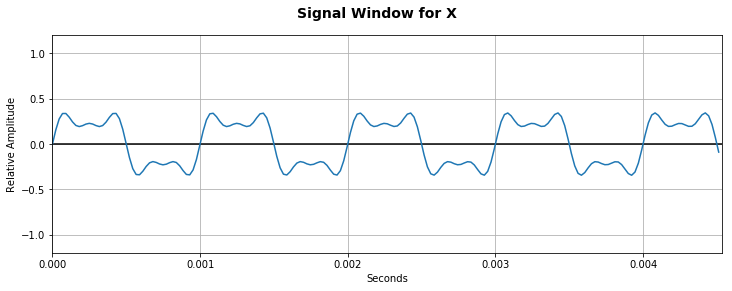

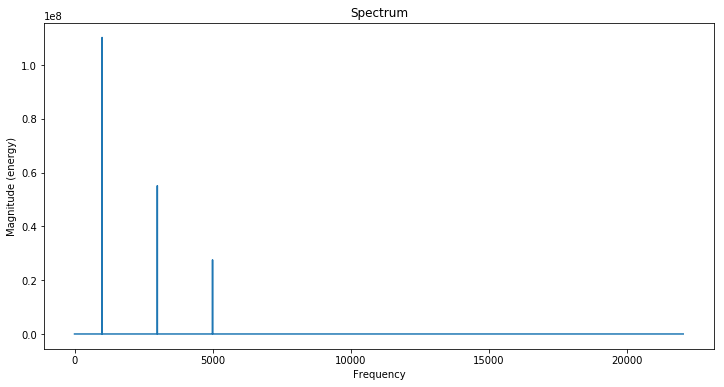

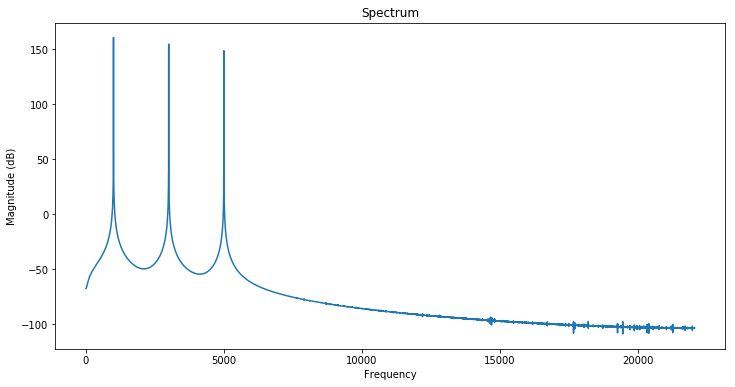

In [327]:
f = 220
T = np.arange(SR*1)
X = 10000 * np.sin( 2 * pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * pi * 5000 * T / SR )
displaySignal(X[:200])

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR,scale='linear')
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

[  7.17008052e-11   1.42249659e-10   1.13104567e-10   1.41966299e-10
   1.68657926e-10   2.02333226e-10   2.70919941e-10   3.22274526e-10
   5.25642850e-10   1.02463731e-09   1.00000000e+04   1.01735864e-09
   5.11055174e-10   3.40075041e-10   2.61876485e-10   1.98729469e-10
   1.85665778e-10   1.48065443e-10   1.40586058e-10   1.23674342e-10]
10000.0
5000.0
2500.0


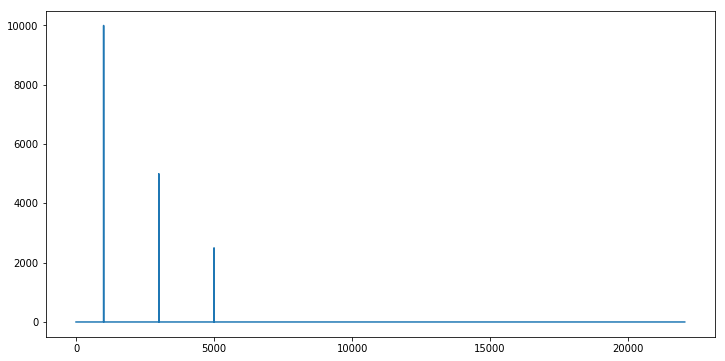

In [328]:
# You can also get the spectrum from the function using the Fast Fourier Transform, which
# we will study in some detail later in the course. For now, we will use it to extract
# a spectrum from a signal

# wrapper around numpy fft to produce real spectrum

# The list returned is the amplitude of sine waves of frequency 0, 1, ..., 22050

def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

T = np.arange(SR*1)
X = 10000 * np.sin( 2 * pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * pi * 5000 * T / SR )

S = realFFT(X)

print(S[990:1010])

print(S[1000])
print(S[3000])
print(S[5000])

plt.figure(figsize=(12,6))
plt.plot(S)
plt.show()


In [329]:
# We can also return a list of triples of form  (f, A, phi) for each frequency
# f detected by the transform
    
def spectrumFFT(X):
    R = np.fft.rfft(X)
    return [ ( k*44100/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k]) ) for k in range(len(R)) ]

S = spectrumFFT(X)
S[995:1005]

[(995.0, 2.0233322628001922e-10, 1.5855977833515635),
 (996.0, 2.7091994092223909e-10, 1.5346728771719891),
 (997.0, 3.2227452642364216e-10, 1.6096699747134098),
 (998.0, 5.2564284979039754e-10, 1.5465845726051444),
 (999.0, 1.0246373117970109e-09, 1.5714467610549159),
 (1000.0, 10000.000000000004, -1.5707963267952203),
 (1001.0, 1.0173586447315281e-09, -1.5640260228177296),
 (1002.0, 5.1105517418081595e-10, -1.587560136210322),
 (1003.0, 3.4007504054527581e-10, -1.5519847740606743),
 (1004.0, 2.6187648478115658e-10, -1.6030590598355186)]

### Displaying Spectrograms

To display spectrograms (spectra over time), we use `specgram`:

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.specgram.html



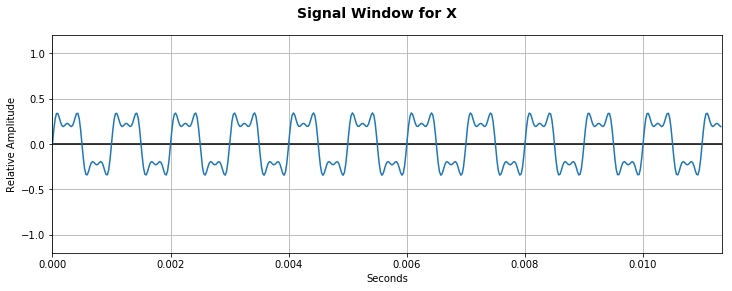

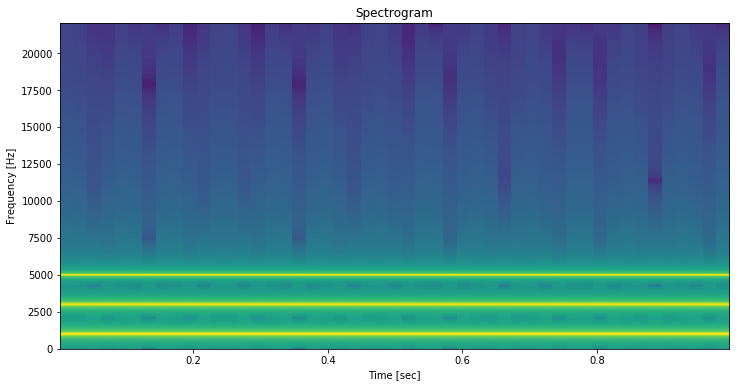

In [330]:
f = 220
T = np.arange(SR*1)
X = 10000 * np.sin( 2 * pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * pi * 5000 * T / SR )

displaySignal(X[:500])

plt.figure(figsize=(12,6))
plt.title('Spectrogram')
plt.specgram(X, NFFT=1024,Fs=SR)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


# Appendix: Customizing Your Plots

One thing you have probably noticed is that when you write "bare-bones" code such as we have above, certain
defaults are used for the size and layout of the figure and the style of the drawing. One of the most noticable is that when you draw multiple lines, Matplotlib will change the color each time you call the same function (notice that this doesn't happen when calling a different function, e.g., plot followed by scatter). 

## Using Colors

Matplotlib cycles through a sequence of 10 colors, which is fine if that is what you want. For my taste, they are pretty ugly, and in the next section we will show you how to use the colors you want. 



The 10 Matplotlib color sequence, starting at 12 o'clock and going clockwise:


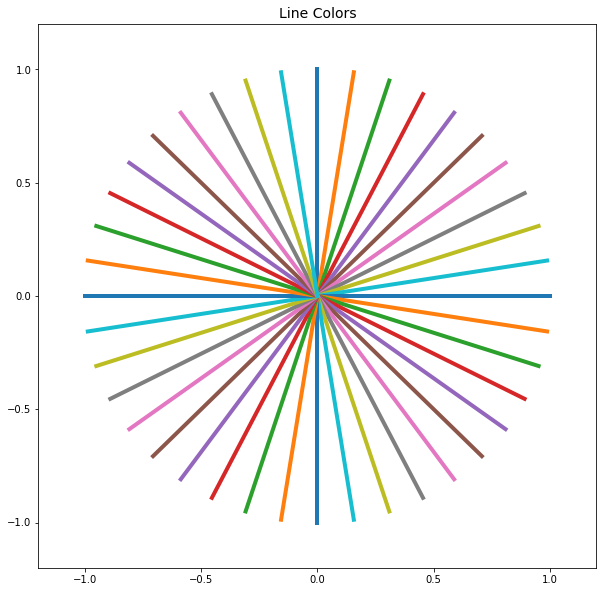

In [331]:
print("\nThe 10 Matplotlib color sequence, starting at 12 o\'clock and going clockwise:")

plt.figure(figsize=(10,10))
for k in np.arange(0,2*np.pi,np.pi/20):                 # arange is like range, except it allows you to use floats
    plt.plot([0,np.sin(k)],[0,np.cos(k)],lw=4)
plt.title('Line Colors',fontsize=14)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()

Here is an example where we simply change the colors of the plot using the appropriate parameter; see a complete list of colors here: https://matplotlib.org/2.0.2/api/colors_api.html

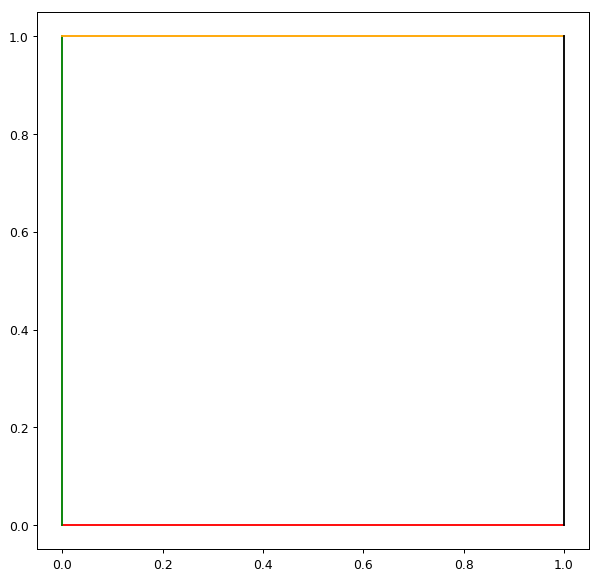

In [332]:
# EXAMPLE: Plotting a square with lines of different colors
plt.figure(num=None, figsize=(8, 8), dpi=89)
plt.plot([0,1],[0,0],color='red') # Line connecting (0,0) to (1,0)
plt.plot([0,0],[0,1],color='green') # Line connecting (0,0) to (0,1)
plt.plot([0,1],[1,1],color='orange') # Line connecting (0,1) to (1,1)
plt.plot([1,1],[0,1],color='black') # Line connecting (1,0) to (1,1)

## Changing the Style of Plots

Here is an example showing how to

  - change the size of the whole figure
  - change the color of lines or points
  - change the style of lines or points
  
To see a complete list of lines styles see:  https://matplotlib.org/2.0.2/api/lines_api.html

To see a complete list of colors see: https://matplotlib.org/2.0.2/api/colors_api.html

To see a complete list of marker (point) styles see:  https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers

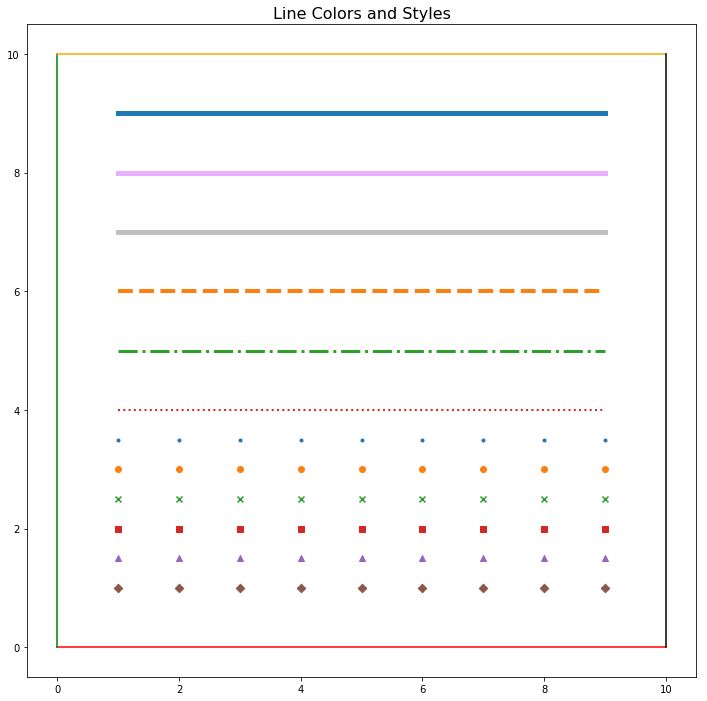

In [333]:
# EXAMPLE: Plotting a square via lines 
plt.figure(figsize=(12, 12))             # the size is (horizontal, vertical)
plt.title("Line Colors and Styles",fontsize=16)
plt.plot([0,10],[0,0],  color='red') # Line connecting (0,0) to (1,0)
plt.plot([0,0],[0,10],  color='green') # Line connecting (0,0) to (0,1)
plt.plot([0,10],[10,10],color='orange') # Line connecting (0,1) to (1,1)
plt.plot([10,10],[0,10],color='black') # Line connecting (1,0) to (1,1)
plt.plot([1,9],[9,9], linewidth=5)    # give a linewidth in points, default is 1.0
plt.plot([1,9],[8,8], linewidth=5,color = '#eaafff')    # for custom color give the RGB value in hex
plt.plot([1,9],[7,7], linewidth=5,color='0.75') # for grey give the percentage of white in quotes
plt.plot([1,9],[6,6], lw=4,linestyle='--') # Linestyles
plt.plot([1,9],[5,5], lw=3,linestyle='-.') # Linestyles
plt.plot([1,9],[4,4], lw=2,linestyle=':') # Linestyles

plt.scatter(range(1,10),[3.5]*9,marker='.')  # various markers, if you don't specify the colors it will cycle
plt.scatter(range(1,10),[3]*9,marker='o')    # through a bunch of colors, starting with blue, orange, green, etc.
plt.scatter(range(1,10),[2.5]*9,marker='x')
plt.scatter(range(1,10),[2]*9,marker='s')
plt.scatter(range(1,10),[1.5]*9,marker='^')
plt.scatter(range(1,10),[1]*9,marker='D')
print()

## Et Cetera

Then you can start getting obsessive, adding gridlines, changing the background color, adding legends, text, and so on. 

Another nice feature of matplotlib is that you can insert simple Latex commands into titles and text.....

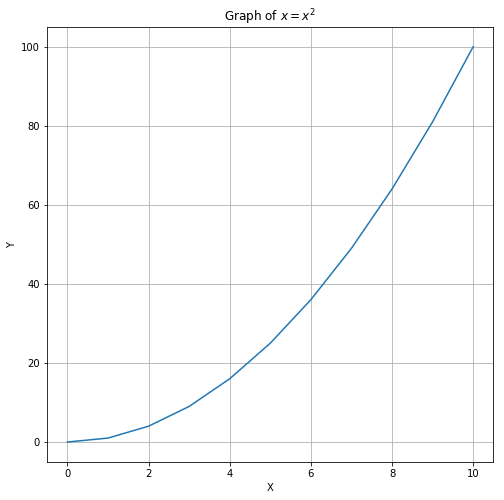

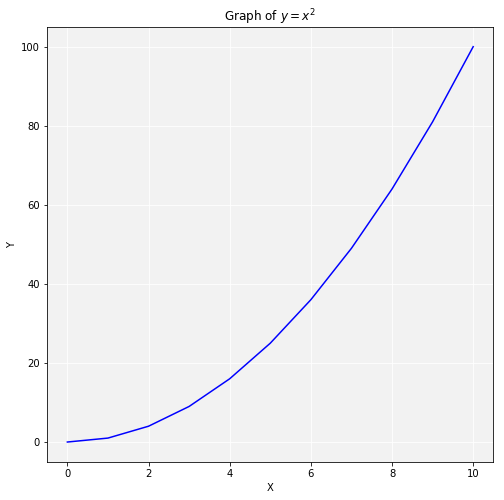

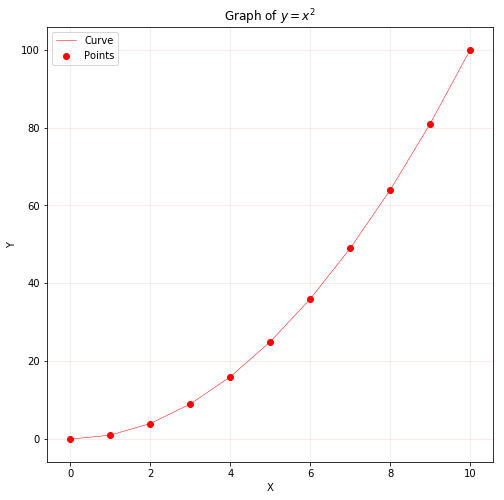

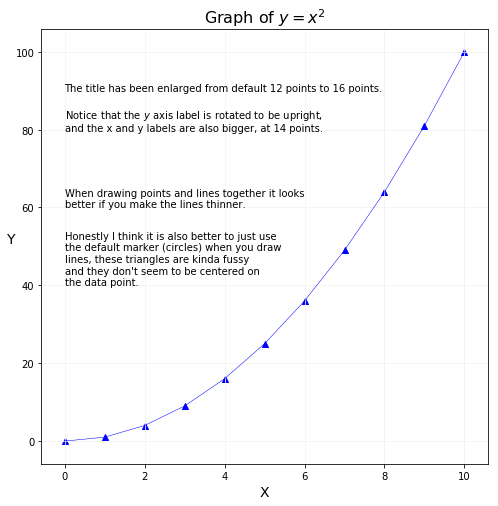

In [334]:
x = [i for i in range(11)]
y = [i**2 for i in x]


plt.figure(figsize=(8, 8))
plt.title('Graph of $x = x^2$')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.plot(x,y)
plt.show()


plt.figure(figsize=(8, 8))
plt.title('Graph of $y = x^2$')
plt.grid(color='w')                # grid of white lines -- don't use points with this, they look funny
plt.gca().set_facecolor('0.95')    # background of light grey
plt.plot(x,y,color='b')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


plt.figure(figsize=(8, 8))
plt.title('Graph of $y = x^2$')
plt.grid(color='r',alpha=0.1)       # alpha sets the transparency, 0 = invisible and 1 = normal           
plt.plot(x,y,color='r',lw=0.5,label='Curve')
plt.scatter(x,y,color='r',marker='o',label='Points')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


plt.figure(figsize=(8, 8))
plt.title('Graph of $y = x^2$',fontsize=16)
plt.xlabel("X",fontsize=14)
plt.ylabel("Y",rotation=0,fontsize=14)
plt.grid(color='0.95')
plt.text(0,90,"The title has been enlarged from default 12 points to 16 points.")
plt.text(0,80,"Notice that the $y$ axis label is rotated to be upright, \nand the x and y labels are also bigger, at 14 points.")   # lower left corner of text string is at point (0,60)
plt.text(0,60,"When drawing points and lines together it looks \nbetter if you make the lines thinner.")
plt.text(0,40,"Honestly I think it is also better to just use\nthe default marker (circles) when you draw \nlines, these triangles are kinda fussy\nand they don't seem to be centered on \nthe data point.")
plt.plot(x,y,color='b',lw=0.5)
plt.scatter(x,y,color='b',marker='^')
plt.show()